# Modelo de LSTM para TESTES

## Bibliotecas

In [26]:
# Estamos usando a versão 3.10.11 do python

# pip install numpy pandas scikit-learn keras pathlib os-sys

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

## Ler bases

In [27]:
# Manipular caminho para pegar o caminho onde as bases estão
base_diretório = Path(os.getcwd())
diretório_princapl = base_diretório.parent
caminho = diretório_princapl / 'Bases' / 'Ethereum Historical Data.csv'

# Ler o arquivo ano.txt e pegar o ano
with open(diretório_princapl/'data'/'ano.txt', 'r') as file:
    ano = int(file.read().strip())

# Ler arquivo da base
acao = pd.read_csv(caminho)
acao['Date'] = pd.to_datetime(acao['Date'])

acao

,Date,Price,Open,High,Low,Volume,Change %
0,2017-01-01,8.20,8.17,8.59,8.03,144920.0,2.50
1,2017-01-02,8.37,8.19,8.50,8.11,101270.0,2.07
2,2017-01-03,9.74,8.43,9.90,8.30,603420.0,16.37
3,2017-01-04,11.00,9.57,11.10,9.44,556250.0,12.94
4,2017-01-05,10.15,11.16,11.70,9.20,490640.0,-7.73
...,...,...,...,...,...,...,...
2881,2024-11-21,3356.43,3069.96,3386.41,3034.44,1060000.0,9.34
2882,2024-11-22,3327.77,3356.42,3424.47,3261.04,661770.0,-0.85
2883,2024-11-23,3393.91,3327.68,3495.09,3316.84,785630.0,1.99
2884,2024-11-24,3361.41,3393.92,3448.58,3285.45,525450.0,-0.96


## Aplicando modelo de ML

In [28]:
# Separar um df no qual vai conter apenas os dado para treinamento
# Que é com base no ano escolhido pelo jogador
df_treinamento = acao[acao['Date'].dt.year < ano]

# Apenas cotação dos dados de treinamento 
cotacao_treinamento = df_treinamento['Price'].to_numpy().reshape(-1, 1)

# Cotação dos dados da base toda
cotacao = acao['Price'].to_numpy().reshape(-1, 1)

# Armazenar tamanho dos dados de treinamento
tamanho_dados_treinamento = int(len(cotacao_treinamento) * 1)

print(f"Tamanho dos dados de treinamento: {tamanho_dados_treinamento}\n")

print(cotacao)

Tamanho dos dados de treinamento: 2191

[[   8.2 ]
 [   8.37]
 [   9.74]
 ...
 [3393.91]
 [3361.41]
 [3466.73]]


In [29]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 
escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                
dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00000000e+00],
       [3.54153386e-05],
       [3.20821303e-04],
       ...,
       [7.05329800e-01],
       [6.98559221e-01],
       [7.20500065e-01]])

In [30]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.00000000e+00, 3.54153386e-05, 3.20821303e-04, 5.83311459e-04,
       4.06234766e-04, 3.91651980e-04, 3.41653855e-04, 4.33317084e-04,
       4.29150574e-04, 5.02064506e-04, 3.31237579e-04, 3.39570599e-04,
       3.06238516e-04, 3.06238516e-04, 3.35404089e-04, 2.93738985e-04,
       3.99985001e-04, 4.14567787e-04, 4.54149636e-04, 5.04147761e-04,
       5.72895183e-04, 5.08314272e-04, 5.35396589e-04, 4.79148699e-04,
       4.74982188e-04, 5.06231016e-04, 4.79148699e-04, 4.81231954e-04,
       4.70815678e-04, 4.85398464e-04, 5.22897058e-04, 5.22897058e-04,
       5.41646355e-04, 5.68728673e-04, 6.49975626e-04, 6.20810053e-04,
       6.49975626e-04, 6.68724923e-04, 6.56225392e-04, 5.62478907e-04,
       6.45809115e-04, 6.52058881e-04, 6.37476095e-04, 6.56225392e-04,
       9.91629481e-04, 9.83296460e-04, 9.83296460e-04, 9.49964376e-04,
       9.56214142e-04, 9.58297397e-04, 8.74967189e-04, 9.62463908e-04,
       9.33298335e-04, 1.05621039e-03, 1.02287831e-03, 1.11454154e-03,
     

In [31]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[0.00000000e+00 3.54153386e-05 3.20821303e-04 ... 1.52077630e-03
  1.59577349e-03 1.92284456e-03]
 [3.54153386e-05 3.20821303e-04 5.83311459e-04 ... 1.59577349e-03
  1.92284456e-03 2.25408214e-03]
 [3.20821303e-04 5.83311459e-04 4.06234766e-04 ... 1.92284456e-03
  2.25408214e-03 2.35199513e-03]
 ...
 [3.29627222e-01 3.25964860e-01 3.27371057e-01 ... 2.54042557e-01
  2.50698932e-01 2.46194934e-01]
 [3.25964860e-01 3.27371057e-01 3.14746530e-01 ... 2.50698932e-01
  2.46194934e-01 2.48457350e-01]
 [3.27371057e-01 3.14746530e-01 3.17254770e-01 ... 2.46194934e-01
  2.48457350e-01 2.48240691e-01]]
[[[0.00000000e+00]
  [3.54153386e-05]
  [3.20821303e-04]
  ...
  [1.52077630e-03]
  [1.59577349e-03]
  [1.92284456e-03]]

 [[3.54153386e-05]
  [3.20821303e-04]
  [5.83311459e-04]
  ...
  [1.59577349e-03]
  [1.92284456e-03]
  [2.25408214e-03]]

 [[3.20821303e-04]
  [5.83311459e-04]
  [4.06234766e-04]
  ...
  [1.92284456e-03]
  [2.25408214e-03]
  [2.35199513e-03]]

 ...

 [[3.29627222e-01]
  [3.2596

In [32]:
#construindo o modelo

modelo = Sequential()

# Primeira camada LSTM
modelo.add(LSTM(100, return_sequences=True, input_shape=(treinamento_x.shape[1], 1)))

# Segunda camada LSTM
modelo.add(LSTM(50, return_sequences=False))

# Camada totalmente conectada com os neuronios
modelo.add(Dense(25))

# Camada final de saída
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [33]:
#copilando o modelo
modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [34]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=10, epochs=20)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0064
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0013
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 7.8606e-04
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 6.7063e-04
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 5.2986e-04
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 5.3289e-04
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 4.2179e-04
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 3.5959e-04
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 3.9423e-04
Epoch 10/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 3.7176e-04
Epoch 11/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 3.4134e-04
Epoch 12/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 4.0098e-04
Epoch 13/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 5.0864e-04
Epoch 14/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - los

In [35]:
# Vriar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [36]:
# Reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [37]:
len(teste_x)

695

In [38]:
#pegando predições do modelo
predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


array([[1211.3505],
       [1214.1324],
       [1225.2594],
       [1229.2753],
       [1261.9004],
       [1267.6562],
       [1281.5972],
       [1281.429 ],
       [1298.9557],
       [1328.6294],
       [1348.2068],
       [1394.5964],
       [1427.8923],
       [1462.5182],
       [1547.915 ],
       [1573.2496],
       [1595.5681],
       [1590.2092],
       [1545.216 ],
       [1563.5874],
       [1655.856 ],
       [1654.5204],
       [1652.3431],
       [1650.9026],
       [1594.9075],
       [1622.9382],
       [1626.2593],
       [1623.1403],
       [1603.2224],
       [1655.7053],
       [1608.5808],
       [1608.8661],
       [1655.4188],
       [1668.4535],
       [1688.175 ],
       [1695.3175],
       [1666.5334],
       [1645.6433],
       [1686.4622],
       [1682.3094],
       [1596.5167],
       [1548.121 ],
       [1556.8513],
       [1544.077 ],
       [1533.6421],
       [1570.5391],
       [1676.5597],
       [1677.7125],
       [1716.2516],
       [1723.5676],


In [39]:
# Criando o grafico do modelo
treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_previsao = pd.DataFrame({"Date": acao['Date'].iloc[tamanho_dados_treinamento:],
                        "Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


In [40]:
treinamento

,Date,Price,Open,High,Low,Volume,Change %
0,2017-01-01,8.20,8.17,8.59,8.03,144920.0,2.50
1,2017-01-02,8.37,8.19,8.50,8.11,101270.0,2.07
2,2017-01-03,9.74,8.43,9.90,8.30,603420.0,16.37
3,2017-01-04,11.00,9.57,11.10,9.44,556250.0,12.94
4,2017-01-05,10.15,11.16,11.70,9.20,490640.0,-7.73
...,...,...,...,...,...,...,...
2186,2022-12-27,1211.60,1228.22,1233.15,1202.02,290020.0,-1.31
2187,2022-12-28,1189.98,1211.60,1214.32,1184.22,407450.0,-1.78
2188,2022-12-29,1200.84,1189.99,1205.34,1187.19,272590.0,0.91
2189,2022-12-30,1199.80,1200.84,1202.13,1186.10,285770.0,-0.09


In [41]:
df_previsao

,Date,Price,predicoes
2191,2023-01-01,1200.52,1211.350464
2192,2023-01-02,1213.93,1214.132446
2193,2023-01-03,1214.57,1225.259399
2194,2023-01-04,1256.92,1229.275269
2195,2023-01-05,1250.95,1261.900391
...,...,...,...
2881,2024-11-21,3356.43,3134.188232
2882,2024-11-22,3327.77,3396.606201
2883,2024-11-23,3393.91,3397.370361
2884,2024-11-24,3361.41,3459.695801


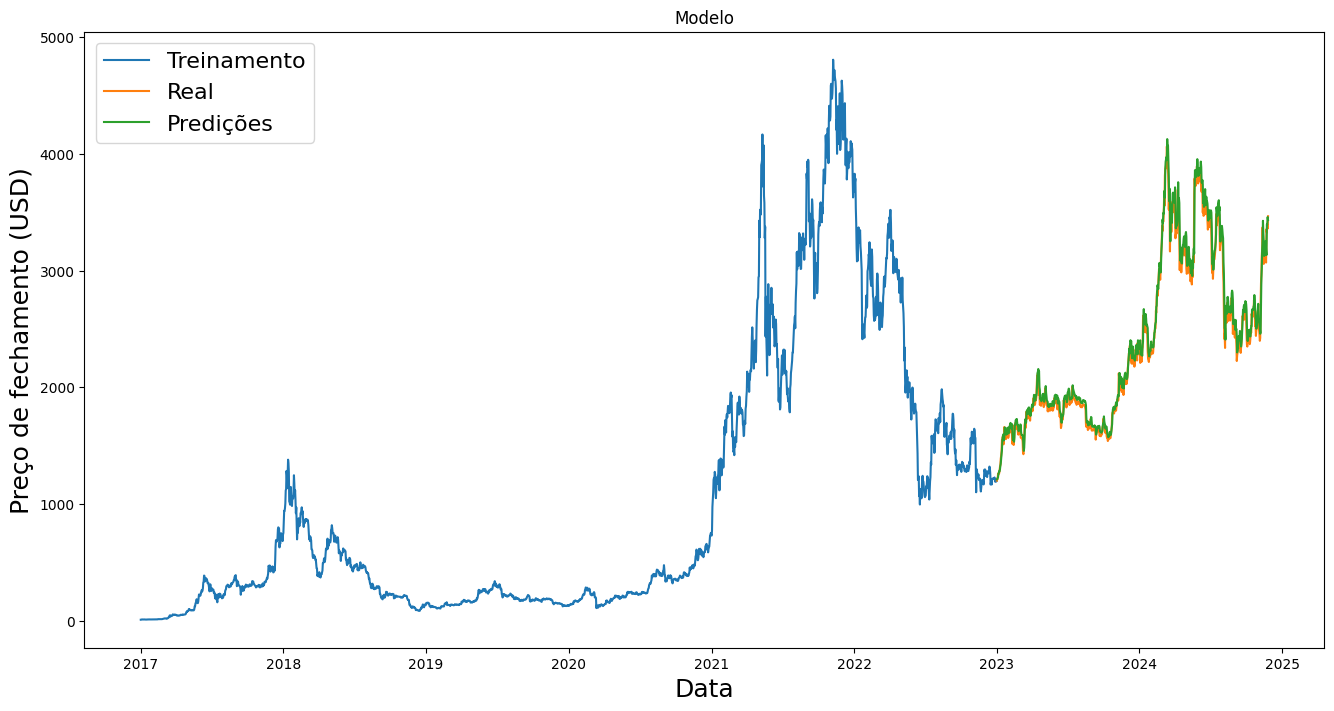

In [42]:
# Setar a data como index dos df (df_previsao e treinamento)
df_previsao.set_index('Date', inplace=True)
treinamento.set_index('Date', inplace=True)

plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento (USD)", fontsize = 18)
plt.plot(treinamento[['Price']])
plt.plot(df_previsao[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [43]:
df_previsao.sort_index()

df_previsao

,Price,predicoes
Date,,
2023-01-01,1200.52,1211.350464
2023-01-02,1213.93,1214.132446
2023-01-03,1214.57,1225.259399
2023-01-04,1256.92,1229.275269
2023-01-05,1250.95,1261.900391
...,...,...
2024-11-21,3356.43,3134.188232
2024-11-22,3327.77,3396.606201
2024-11-23,3393.91,3397.370361


In [44]:
df_previsao_semanal = df_previsao
df_previsao_semanal['Semana'] = ((df_previsao_semanal.index - df_previsao_semanal.index.min()).days // 7) + 1
df_previsao_semanal.head(30)

,Price,predicoes,Semana
Date,,,
2023-01-01,1200.52,1211.350464,1
2023-01-02,1213.93,1214.132446,1
2023-01-03,1214.57,1225.259399,1
2023-01-04,1256.92,1229.275269,1
2023-01-05,1250.95,1261.900391,1
2023-01-06,1269.14,1267.656250,1
2023-01-07,1263.90,1281.597168,1
2023-01-08,1288.38,1281.428955,2
2023-01-09,1320.51,1298.955688,2


In [45]:
df_previsao_semanal = df_previsao_semanal.reset_index() 
df_previsao_semanal

,Date,Price,predicoes,Semana
0,2023-01-01,1200.52,1211.350464,1
1,2023-01-02,1213.93,1214.132446,1
2,2023-01-03,1214.57,1225.259399,1
3,2023-01-04,1256.92,1229.275269,1
4,2023-01-05,1250.95,1261.900391,1
...,...,...,...,...
690,2024-11-21,3356.43,3134.188232,99
691,2024-11-22,3327.77,3396.606201,99
692,2024-11-23,3393.91,3397.370361,99
693,2024-11-24,3361.41,3459.695801,100


# Metricas para calcular nosso modelo de ML

### Mean Absolute Error (MAE) e Mean Absolute Percentage Error (MAPE)

In [46]:
# A média das diferenças absolutas entre as previsões e os valores reais. Penaliza todos os erros da mesma forma

mae = mean_absolute_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 65.06


In [47]:
# Calcular o MAPE
mape = mean_absolute_percentage_error(df_previsao['Price'], df_previsao['predicoes'])

print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} = {100*mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.0270 = 2.70%


### Root Mean Squared Error (RMSE)

In [48]:
# A raiz quadrada da média dos erros ao quadrado. Dá mais peso a grandes erros

rmse = mean_squared_error(df_previsao['Price'], df_previsao['predicoes'], squared=False)
mean_price = df_previsao['Price'].mean()

print(f"RMSE: {rmse}")
print(f"RMSE percentual: {(rmse / mean_price)} = {(rmse / mean_price)*100:.3}%")

RMSE: 89.96190700151062
RMSE percentual: 0.03815283340610046 = 3.82%


c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Directional Accuracy (Semanal)

In [49]:
df_previsao_semanal.reset_index() 
# Agrupar por semana e calcular o preço médio semanal para real e previsões
df_teste_semana = df_previsao_semanal.groupby('Semana').agg({
    'predicoes': 'first',   # pegar a previsão do primeiro dia da semana
    'Price': 'first',       # pegar o valor real do primeiro dia da semana
    'Date': 'first'         # Pega a primeira data da semana 
})

# Adicionar colunas de mês e ano com base na coluna 'Data'
df_teste_semana['Mes'] = df_teste_semana['Date'].dt.month
df_teste_semana['Ano'] = df_teste_semana['Date'].dt.year

# Calcular a variação percentual semanal para Price e Predicoes
df_teste_semana['Variação Real (%)'] = df_teste_semana['Price'].pct_change() * 100
df_teste_semana['Variação Prevista (%)'] = df_teste_semana['predicoes'].pct_change() * 100


# Remover NaN (primeira linha não terá variação por não ter valor anterior)
df_teste_semana = df_teste_semana.dropna()

# Calcular se a direção do valor previsto foi igual ao real (1 = acertou | 0 = errou)
df_teste_semana['direcao_correta'] = np.where(
    (df_teste_semana['Variação Real (%)'] > 0) & (df_teste_semana['Variação Prevista (%)'] > 0) |
    (df_teste_semana['Variação Real (%)'] < 0) & (df_teste_semana['Variação Prevista (%)'] < 0),
    1, 0
)

# Calcular a métrica de Erro de Direção (Directional Accuracy)
directional_accuracy = df_teste_semana['direcao_correta'].mean()

# Exibir resultados
print(f"Directional Accuracy (Semanal): {directional_accuracy * 100:.2f}%")

df_teste_semana

Directional Accuracy (Semanal): 87.88%


,predicoes,Price,Date,Mes,Ano,Variação Real (%),Variação Prevista (%),direcao_correta
Semana,,,,,,,,
2,1281.428955,1288.38,2023-01-08,1,2023,7.318495,5.785155,1
3,1547.915039,1552.69,2023-01-15,1,2023,20.514910,20.796013,1
4,1654.520386,1627.03,2023-01-22,1,2023,4.787820,6.887031,1
5,1603.222412,1645.97,2023-01-29,1,2023,1.164084,-3.100473,0
6,1695.317505,1629.44,2023-02-05,2,2023,-1.004271,5.744374,0
...,...,...,...,...,...,...,...,...
96,2526.618896,2507.39,2024-10-27,10,2024,-8.731909,-6.491369,1
97,2548.495850,2457.68,2024-11-03,11,2024,-1.982540,0.865865,0
98,3182.199219,3186.05,2024-11-10,11,2024,29.636486,24.865782,1


In [50]:
# df_teste_semana.to_csv("previsão semanal - Bitcoin.csv")